In [1]:
import os
import json

import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [2]:
def get_pcm_data(file_path, sample_rate):
    pcm, _ = librosa.load(file_path,
                          sr=sample_rate)
    trimmed_data, _ = librosa.effects.trim(y=pcm)
    return trimmed_data

def get_mfcc_features(pcm_data, sample_rate, n_mels, n_mfcc):
    # calculate MFCCs (Mel-Frequency Cepstral Coefficients)
    mel_spectrum = librosa.feature.melspectrogram(pcm_data,
                                                  sr=sample_rate,
                                                  n_mels=n_mels)
    log_spectrum = librosa.amplitude_to_db(mel_spectrum,
                                           ref=np.max)
    mfcc = librosa.feature.mfcc(S=log_spectrum,
                                sr=sample_rate,
                                n_mfcc=n_mfcc)
    # standardize feature for equal variance
    delta_mfcc = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    feature_vector = np.concatenate((
        np.mean(mfcc, 1),
        np.mean(delta_mfcc, 1),
        np.mean(delta2_mfcc, 1)))
    feature_vector = (
        feature_vector - np.mean(feature_vector)
    ) / np.std(feature_vector)
    return feature_vector

In [3]:
def analyse_file(file, sr, blocks_per_sec, mfcc_size, mels_num):
    data = get_pcm_data(file, sr)
    data_size = len(data)
    block_size = sr // blocks_per_sec
    
    print('data_size', data_size)
    print('block_size', block_size)

    start = 0
    end = block_size

    melfcs = []

    while end <= data_size:
        data_slice = data[start:end]
        melfc = get_mfcc_features(data_slice, sr, mels_num, mfcc_size)
        melfcs.append(melfc)
        start += block_size
        end += block_size

    return melfcs, data

In [4]:
def get_pca(features, components):
    pca = PCA(n_components=components)
    transformed = pca.fit(features).transform(features)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(transformed)
    return scaler.transform(transformed), pca, scaler

In [5]:
def encode_point(p, grid_size):
    return [min(round(grid_size * max(f, 0)), grid_size - 1) for f in p]

def encode_data(data, grid_size):
    '''Encode 2D positions into a grid and convert this to index values'''
    new_data = []
    m = np.zeros((grid_size, grid_size))
    for point in data:
        ac_converted = np.array(encode_point(point, grid_size), dtype='int32')
        ac_indexed = np.ravel_multi_index(ac_converted, m.shape)
        new_data.append(ac_indexed)
    return np.array(new_data)

In [6]:
sr = 44100
blocks_per_sec = 10
mfcc_size = 13
mels_num = 128
grid_size = 10
hop_length = 512

#file1 = './files/wav/test-sample-7.wav'
#file2 = './files/wav/test-sample-2.wav'

file1 = '../../projects/tomomibot/material/tomomi-original-1.wav'
file2 = '../../projects/tomomibot/material/tomomi-original-2.wav'

# Open and analyze sound files
melfcs_1, y_1 = analyse_file(file1, sr, blocks_per_sec, mfcc_size, mels_num)
melfcs_2, y_2 = analyse_file(file2, sr, blocks_per_sec, mfcc_size, mels_num)

# Get PCA of first file
pca_1, pca_instance, pca_scaler = get_pca(melfcs_1, 2)

# Project second sequence into PCA of first
pca_2 = pca_instance.transform(melfcs_2)
pca_2 = pca_scaler.transform(pca_2)

# Put them together into one file
files_len = max(len(pca_1), len(pca_2))
sequence = []
print('Length of both sequences:', len(pca_1), len(pca_2))

for i in range(files_len):
    frame = []
    
    if i < len(pca_1):
        frame.append([pca_1[i][0], pca_1[i][1]])
    else:
        frame.append([0.0, 0.0])
        
    if i < len(pca_2):
        frame.append([pca_2[i][0], pca_2[i][1]])
    else:
        frame.append([0.0, 0.0])
    
    sequence.append(frame)
    
# Save as .json file
data_path = os.path.join(os.getcwd(), 'files', 'json', 'sequence3.json')
with open(data_path, 'w') as file:
    json.dump(sequence, file, indent=2, separators=(',', ': '))

data_size 158732800
block_size 4410


/Users/adz/.pyenv/versions/3.6.5/envs/notebook/lib/python3.6/site-packages/scipy/signal/_savitzky_golay.py:135: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  coeffs, _, _, _ = lstsq(A, y)


data_size 158758400
block_size 4410
Length of both sequences: 35993 35999


In [7]:
# Encode sequences
slice_size = 100

sequence1 = encode_data(pca_1, grid_size)[:slice_size]
sequence2 = encode_data(pca_2, grid_size)[:slice_size]

audio_slice_size = slice_size * (sr // blocks_per_sec)

audio_1 = y_1[:audio_slice_size]
audio_2 = y_2[:audio_slice_size]

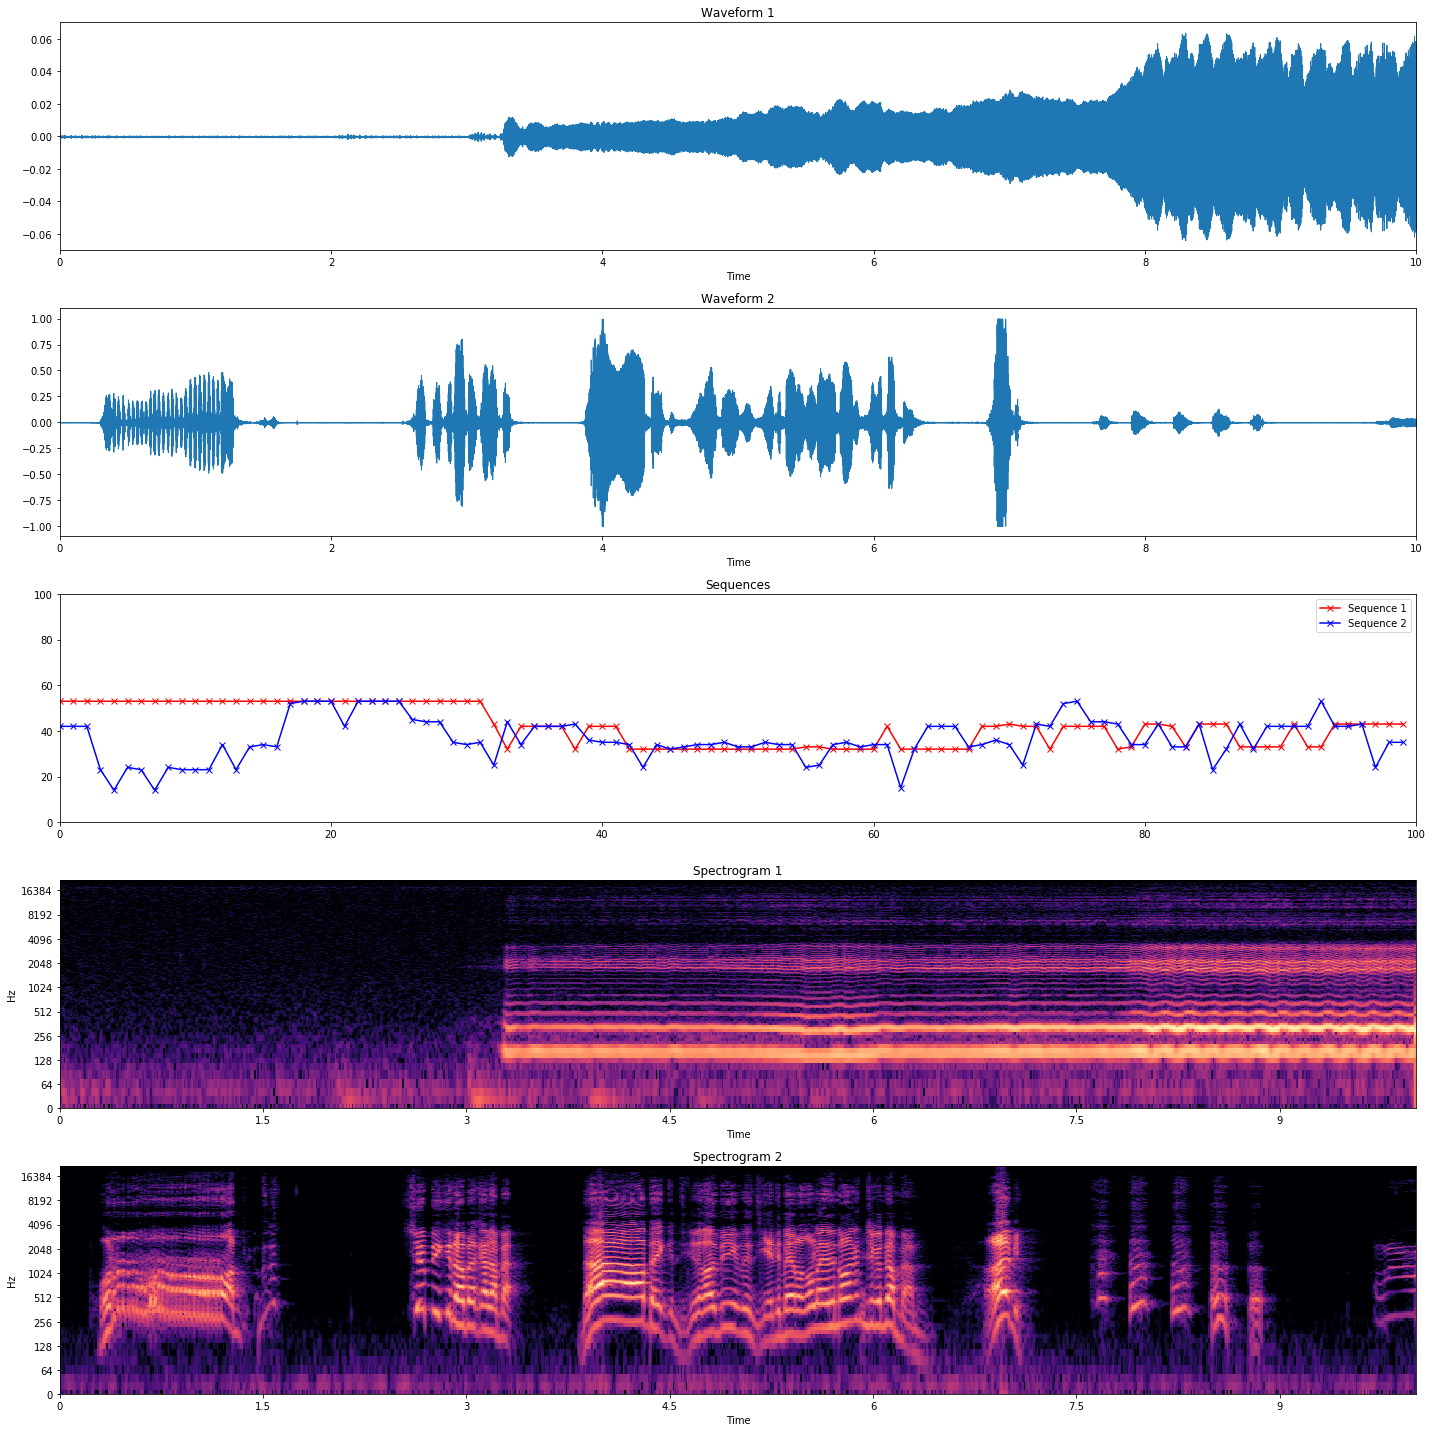

In [8]:
plt.figure(figsize=(20, 20))

# Draw waveform with onset markings 1
plt.subplot(5, 1, 1, title="Waveform 1")
librosa.display.waveplot(audio_1, sr=sr)

# Draw waveform with onset markings 2
plt.subplot(5, 1, 2, title="Waveform 2")
librosa.display.waveplot(audio_2, sr=sr)

# Draw waveform with onset markings
plt.subplot(5, 1, 3, title="Sequences")
plt.plot(range(len(sequence1)), sequence1, color='red', marker='x', label='Sequence 1')
plt.plot(range(len(sequence2)), sequence2, color='blue', marker='x', label='Sequence 2')
plt.axis([0, max(len(sequence1), len(sequence2)), 0, 100])
plt.legend(frameon=True, framealpha=0.8)

# Draw spectrogram 1
ax = plt.subplot(5, 1, 4, title="Spectrogram 1")
D = librosa.stft(audio_1)
librosa.display.specshow(
    librosa.amplitude_to_db(librosa.magphase(D)[0], ref=np.max),
    sr=sr,
    hop_length=hop_length,
    y_axis='log',
    x_axis='time')

# Draw spectrogram 2
ax = plt.subplot(5, 1, 5, title="Spectrogram 2")
D = librosa.stft(audio_2)
librosa.display.specshow(
    librosa.amplitude_to_db(librosa.magphase(D)[0], ref=np.max),
    sr=sr,
    hop_length=hop_length,
    y_axis='log',
    x_axis='time')

plt.tight_layout()

In [9]:
ipd.Audio(audio_1, rate=sr)

In [10]:
ipd.Audio(audio_2, rate=sr)